## Goal

* Predict which customers are more likely to convert on offers 
* Identify important features highly correlated with offer conversion


## Table of Contents
* Import packages
* Read train and test csv files
* Classification model approach 1
* Classification model approach 2

## Import Packages

In [1]:
%matplotlib inline
import os
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Read Train and Test CSV files

In [2]:
train = pd.read_csv('../data/train_starbucks.csv.gz', compression='gzip')
test = pd.read_csv('../data/test_starbucks.csv.gz', compression='gzip')

print(train.shape)
print(test.shape)

(11390, 53)
(5610, 53)


In [3]:
train.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,days_registered,days_reg_quantile_range,days_reg_quantile_label,income,income_quantile_range,income_quantile_label,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA,num_offer_received,num_bogo_offer_received,num_info_offer_received,num_discount_offer_received,num_offer_viewed,num_offer_completed,num_offer_completed_viewed,num_offer_completed_not_viewed,num_transactions_no_oc,num_transactions_oc_direct,num_transactions_oc_indirect,percent_oc_direct_transactions,offer_view_rate,offer_completion_rate,total_reward_amount,avg_reward_per_oc_transaction,transaction_oc_amount,transaction_aos_oc,transaction_no_oc_amount,transaction_aos_no_oc,num_bogo_offer_viewed,num_info_offer_viewed,num_discount_offer_viewed,num_bogo_offer_completed,num_info_offer_completed,num_discount_offer_completed,median_offer_duration,avg_offer_completion_time,avg_hrs_bw_transactions,num_oc_ch_web,num_oc_ch_social,num_oc_ch_mobile,num_oc_ch_email,avg_offer_received_freq,info_view_rate
0,F,49.0,"(41.0, 53.0]",20-40Q,8afd61052075479bacfe7dec6a27111c,2018-03-14,134,"(88.9, 177.8]",10-20Q,75000.0,"(66000.0, 82000.0]",60-80Q,65.38,3.0,21.79,0,0,0,4.0,2.0,1.0,1.0,4.0,1.0,1.0,0.0,2.0,1.0,0.0,0.3333,1.0,0.33,2.0,2.00,16.67,16.670000,48.71,24.355000,2.0,1.0,1.0,0.0,0.0,1.0,240.0,114.0,135.000000,1.0,1.0,1.0,1.0,136.0,1.0
1,M,68.0,"(57.0, 68.0]",60-80Q,0f4ea68d60614ce2a683c039425f160c,2017-10-09,290,"(238.0, 298.0]",30-40Q,46000.0,"(29999.999, 47000.0]",0-20Q,64.10,4.0,16.03,0,0,0,6.0,4.0,0.0,2.0,6.0,3.0,2.0,1.0,1.0,2.0,1.0,0.5000,1.0,0.50,20.0,6.67,38.65,12.883333,25.45,25.450000,4.0,0.0,2.0,2.0,0.0,1.0,168.0,74.0,24.000000,2.0,2.0,2.0,3.0,115.2,0.0
2,Missing,55.0,"(53.0, 57.0]",40-60Q,21235376597f4d94af106ebba288304c,2015-09-12,1048,"(871.0, 1059.0]",80-90Q,64000.0,"(61000.0, 66000.0]",40-60Q,21.31,12.0,1.78,1,1,1,3.0,0.0,1.0,2.0,3.0,1.0,1.0,0.0,11.0,0.0,1.0,0.0000,1.0,0.50,3.0,3.00,1.02,1.020000,20.29,1.844545,0.0,1.0,2.0,0.0,0.0,1.0,168.0,96.0,43.090909,1.0,1.0,1.0,1.0,204.0,1.0
3,M,65.0,"(57.0, 68.0]",60-80Q,9c9d2659c4ec499288a96dec70fae500,2017-01-12,560,"(516.4, 704.0]",60-70Q,76000.0,"(66000.0, 82000.0]",60-80Q,154.40,6.0,25.73,0,0,0,5.0,1.0,1.0,3.0,4.0,4.0,3.0,1.0,3.0,3.0,0.0,0.5000,0.8,1.00,14.0,4.67,85.47,28.490000,68.93,22.976667,1.0,1.0,2.0,1.0,0.0,3.0,204.0,75.0,81.000000,4.0,2.0,3.0,4.0,126.0,1.0
4,F,35.0,"(17.999, 41.0]",0-20Q,75f1a3a88b5845feba167c6380f4dba2,2018-05-27,60,"(-0.001, 88.9]",0-10Q,38000.0,"(29999.999, 47000.0]",0-20Q,17.69,6.0,2.95,0,0,0,5.0,3.0,0.0,2.0,3.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0000,0.6,0.00,0.0,0.00,0.00,0.000000,17.69,2.948333,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.800000,0.0,0.0,0.0,0.0,126.0,0.0


# Classification Model Approach 1: Predicting if customer will complete offer or not (regardless of offer type)

## Make copies of train and test

In [4]:
X_train = train.copy()
X_test = test.copy()

## Identify categorical columns

In [5]:
X_train.select_dtypes(include='object').columns

Index(['gender', 'age_quantile_range', 'age_quantile_label', 'customer_id',
       'date_registered', 'days_reg_quantile_range', 'days_reg_quantile_label',
       'income_quantile_range', 'income_quantile_label'],
      dtype='object')

## Drop constant and generic columns in train and test

In [6]:
# drop constant and generic features
DROP_GENERIC_COLUMNS = ['customer_id', 'gender_NA', 'income_NA', 'age_NA']
DROP_CONSTANT_COLUMNS = []

for column in X_train.columns:
    if X_train[column].nunique() == 1:
        print(column)
        DROP_CONSTANT_COLUMNS.append(column)

X_train.drop(columns=DROP_CONSTANT_COLUMNS + DROP_GENERIC_COLUMNS, inplace = True)
X_test.drop(columns=DROP_CONSTANT_COLUMNS + DROP_GENERIC_COLUMNS, inplace = True)

num_info_offer_completed


## Transform Gender: One Hot Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Re-label 'O' to 'Missing' for gender
X_train['gender'] = X_train['gender'].apply(lambda x: 'Missing' if x == 'O' else x)
X_test['gender'] = X_test['gender'].apply(lambda x: 'Missing' if x == 'O' else x)

# integer encode
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(X_train.gender)
test_integer_encoded = label_encoder.transform(X_test.gender)

# binary encode
n_train = len(train_integer_encoded)
n_test = len(test_integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
train_integer_encoded_reshape = train_integer_encoded.reshape(n_train, 1)
test_integer_encoded_reshape = test_integer_encoded.reshape(n_test, 1)

train_onehot_encoded = onehot_encoder.fit_transform(train_integer_encoded_reshape)
test_onehot_encoded = onehot_encoder.transform(test_integer_encoded_reshape)


# generate column names for gender feature
# append one-hot-encoded gender columns to X_train and X_test

train_label_mapping = [item for item in zip(train_integer_encoded, np.array(X_train.gender))]
train_label_mapping = sorted(set(train_label_mapping))
train_column_names = ['gender_' + i[1] for i in train_label_mapping]    
train_ohe_gender = pd.DataFrame(train_onehot_encoded, columns=train_column_names)
X_train = pd.concat([X_train, train_ohe_gender], axis=1)

test_label_mapping = [item for item in zip(test_integer_encoded, np.array(X_test.gender))]
test_label_mapping = sorted(set(test_label_mapping))
test_column_names = ['gender_' + i[1] for i in test_label_mapping]
test_ohe_gender = pd.DataFrame(test_onehot_encoded, columns=test_column_names)
X_test = pd.concat([X_test, test_ohe_gender], axis=1)

## Transform categorical to numeric ordinal columns & drop redundant columns

In [8]:
# ordinal (categorical) encoding
DROP_REDUNDANT_COLUMNS = ['gender', 'age_quantile_range', 'date_registered', 
                          'age_quantile_label', 'days_reg_quantile_label','income_quantile_label', 
                          'days_reg_quantile_range', 'income_quantile_range']

ORDINAL_COLUMNS = ['age_quantile_label', 'days_reg_quantile_label','income_quantile_label']

# integer encode
label_encoder = LabelEncoder()

for column in ORDINAL_COLUMNS:
    train_labels = X_train[column]
    test_labels = X_test[column]
    
    train_integer_encoded = label_encoder.fit_transform(train_labels)
    test_integer_encoded = label_encoder.transform(test_labels)
    
    adj_column = column + '_enc'
    
    train_column = pd.DataFrame(train_integer_encoded, columns=[adj_column])
    test_column = pd.DataFrame(test_integer_encoded, columns=[adj_column])
    
    X_train = pd.concat([X_train, train_column], axis=1)
    X_test = pd.concat([X_test, test_column], axis=1)

X_train.drop(columns=DROP_REDUNDANT_COLUMNS, inplace=True)
X_test.drop(columns=DROP_REDUNDANT_COLUMNS, inplace=True)

## Feature Selection: Identify highly correlated features and remove

In [9]:
cor_matrix = X_train.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)


['num_transactions_no_oc', 'num_oc_ch_web', 'num_oc_ch_mobile', 'num_oc_ch_email']


In [10]:
print(X_train.shape)
print(X_test.shape)

(11390, 42)
(5610, 42)


In [11]:
X_train.head()

,age,days_registered,income,transaction_amount,transaction_cnt,transaction_aos,num_offer_received,num_bogo_offer_received,num_info_offer_received,num_discount_offer_received,num_offer_viewed,num_offer_completed,num_offer_completed_viewed,num_offer_completed_not_viewed,num_transactions_oc_direct,num_transactions_oc_indirect,percent_oc_direct_transactions,offer_view_rate,offer_completion_rate,total_reward_amount,avg_reward_per_oc_transaction,transaction_oc_amount,transaction_aos_oc,transaction_no_oc_amount,transaction_aos_no_oc,num_bogo_offer_viewed,num_info_offer_viewed,num_discount_offer_viewed,num_bogo_offer_completed,num_discount_offer_completed,median_offer_duration,avg_offer_completion_time,avg_hrs_bw_transactions,num_oc_ch_social,avg_offer_received_freq,info_view_rate,gender_F,gender_M,gender_Missing,age_quantile_label_enc,days_reg_quantile_label_enc,income_quantile_label_enc
0,49.0,134,75000.0,65.38,3.0,21.79,4.0,2.0,1.0,1.0,4.0,1.0,1.0,0.0,1.0,0.0,0.3333,1.0,0.33,2.0,2.00,16.67,16.670000,48.71,24.355000,2.0,1.0,1.0,0.0,1.0,240.0,114.0,135.000000,1.0,136.0,1.0,1.0,0.0,0.0,1,1,3
1,68.0,290,46000.0,64.10,4.0,16.03,6.0,4.0,0.0,2.0,6.0,3.0,2.0,1.0,2.0,1.0,0.5000,1.0,0.50,20.0,6.67,38.65,12.883333,25.45,25.450000,4.0,0.0,2.0,2.0,1.0,168.0,74.0,24.000000,2.0,115.2,0.0,0.0,1.0,0.0,3,3,0
2,55.0,1048,64000.0,21.31,12.0,1.78,3.0,0.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0000,1.0,0.50,3.0,3.00,1.02,1.020000,20.29,1.844545,0.0,1.0,2.0,0.0,1.0,168.0,96.0,43.090909,1.0,204.0,1.0,0.0,0.0,1.0,2,8,2
3,65.0,560,76000.0,154.40,6.0,25.73,5.0,1.0,1.0,3.0,4.0,4.0,3.0,1.0,3.0,0.0,0.5000,0.8,1.00,14.0,4.67,85.47,28.490000,68.93,22.976667,1.0,1.0,2.0,1.0,3.0,204.0,75.0,81.000000,2.0,126.0,1.0,0.0,1.0,0.0,3,6,3
4,35.0,60,38000.0,17.69,6.0,2.95,5.0,3.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.6,0.00,0.0,0.00,0.00,0.000000,17.69,2.948333,3.0,0.0,0.0,0.0,0.0,0.0,0.0,142.800000,0.0,126.0,0.0,1.0,0.0,0.0,0,0,0


## Define Binary Target Variable

In [12]:
def create_target_variable(data):
    if data['offer_view_rate'] >= 0.5 and data['offer_completion_rate'] >= 0.5:
        return 1
    else:
        return 0

In [13]:
y_train = X_train.apply(create_target_variable, axis=1)
y_test = X_test.apply(create_target_variable, axis=1)

In [14]:
X_train.drop(columns=['offer_view_rate', 'offer_completion_rate'], inplace=True)
X_test.drop(columns=['offer_view_rate', 'offer_completion_rate'], inplace=True)

In [15]:
rf_estimator = RandomForestClassifier(random_state=0)
rf_estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [16]:
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
# make y predictions for X_test with best gridsearch estimator
y_pred = rf_estimator.predict(X_test)

In [18]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9869875222816399


In [19]:
def feature_ranking(train_data, n_features, feature_importance_scores):
    """
    train_data: training pandas dataframe data
    n_features: an integer; number of features in X_train
    feature_importance_scores: numpy ndarray from sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    feature_importances = {}
    for idx in range(n_features):
        key = train_data.columns[idx]
        val = feature_importance_scores[idx]
        feature_importances[key] = val

    important_features = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
    ranked_features = important_features.sort_values('importance', ascending=False)
    
    return ranked_features

In [20]:
feature_ranking(X_train, len(X_train.columns), rf_estimator.feature_importances_)
# 'avg_reward_per_oc_transaction', 'num_discount_offer_completed', 'num_bogo_offer_completed', 'num_bogo_offer_viewed',
# 'num_discount_offer_received', 'num_bogo_offer_received', 'num_discount_offer_viewed', 'num_info_offer_viewed', 'num_info_offer_received'


,importance
num_offer_completed,0.148635
transaction_oc_amount,0.092855
transaction_amount,0.076209
num_transactions_oc_direct,0.062785
num_offer_completed_viewed,0.054935
num_offer_viewed,0.051619
transaction_aos_oc,0.049934
num_offer_received,0.042567
percent_oc_direct_transactions,0.042216
total_reward_amount,0.041921


In [21]:
# paramters: models (dict), X_train (dataframe, array), y_train (dataframe, array)
def output_model_stats(models, X_train, y_train):
    '''
     Function outputs these model metrics:
        'accuracy','accuracy_cv_score','accuracy_cv_stddev',
        'precision_score','recall_score','f1_score',
        'roc_auc_score (cross_val_score)','roc_auc_score (cross_val_predict)'
    '''
    
    model_stats = {}
    for mname, minst in models.items():
        model_scores = []

        # create pipeline with scaler and model instantiation steps
        model_pipe = make_pipeline(StandardScaler(), minst)

        # fit training data and run model score
        model_pipe.fit(X_train, y_train)
        model_scores.append(model_pipe.score(X_train, y_train))

        # implement cross validation model accuracy score
        scores = cross_val_score(model_pipe, X_train, y_train, cv=10, scoring='accuracy')
        model_scores.append(scores.mean())
        model_scores.append(scores.std())

        # implement cross validation predictions on training data
        y_train_cv_pred = cross_val_predict(model_pipe, X_train, y_train, cv=10)

        # calculate precision and recall
        p = precision_score(y_train, y_train_cv_pred)
        r = recall_score(y_train, y_train_cv_pred)
        model_scores.append(p)
        model_scores.append(r)

        # calculate F1 score
        f1_score = 2*(p*r)/(p+r)
        model_scores.append(f1_score)

        # calculate ROC AUC score using cross_val_score
        roc_auc_cvs = cross_val_score(model_pipe, X_train, y_train, cv=10, scoring='roc_auc').mean()
        model_scores.append(roc_auc_cvs)

        # create dictionary key/pair value
        model_stats[mname] = model_scores
    
    colnames = ['accuracy','accuracy_cv_score','accuracy_cv_stddev',
                'precision_score','recall_score','f1_score',
                'roc_auc_score (cross_val_score)']

    # put model stats into a dataframe
    df_model_stats = pd.DataFrame.from_dict(model_stats, orient='index', columns=colnames)
    df_model_stats_ranked = df_model_stats.sort_values(by='accuracy', ascending=False)

    # output is a dataframe
    return df_model_stats_ranked

In [22]:
models = {"RF": RandomForestClassifier(random_state=0)}
output_model_stats(models, X_train, y_train)

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
RF,1.0,0.985777,0.003209,0.982821,0.991805,0.987292,0.999195


# Classification Model Approach 2: Predicting individual offer completion

## Create Time-Series Chart: Offers Received, Viewed, and Completed

In [23]:
import sys
sys.path.insert(0, '..')
from base_transforms import BaseTransformDF

df_base = BaseTransformDF()
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)
df_transcript = df_base.create_transcript_copy(transcript)

In [24]:
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
df_portfolio = df_base.portfolio_expanded(portfolio)

def create_new_offer_type(data):
    rw = str(data.reward)
    dif = str(data.difficulty)
    dur = str(data.duration)
    otype = data.offer_type
    offer_type_v2 = otype+'-'+rw+'-'+dif+'-'+dur
    return offer_type_v2

df_portfolio['offer_type_v2'] = df_portfolio.apply(create_new_offer_type, axis=1)
df_portfolio.drop(columns=['channels'], inplace=True)
df_portfolio

,reward,difficulty,duration,offer_type,offer_id,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_informational,type_discount,offer_type_v2
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,1,0,0,bogo-10-10-168
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4,1,1,1,1,1,0,0,bogo-10-10-120
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,1,0,0,1,0,informational-0-0-96
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,1,1,1,0,1,0,0,bogo-5-5-168
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,1,1,0,0,0,0,1,discount-5-20-240
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,4,1,1,1,1,0,0,1,discount-3-7-168
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,4,1,1,1,1,0,0,1,discount-2-10-240
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,3,0,1,1,1,0,1,0,informational-0-0-72
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4,1,1,1,1,1,0,0,bogo-5-5-120
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,0,0,1,discount-2-10-168


In [25]:
df_received = df_base.create_df_base_received(df_transcript)
df_received_expanded = df_received.merge(df_portfolio, how='left', on='offer_id')
df_received_expanded[df_received_expanded.offer_received_time==0].groupby('offer_type_v2')['offer_id'].count()

offer_type_v2
bogo-10-10-120          1218
bogo-10-10-168          1292
bogo-5-5-120            1263
bogo-5-5-168            1245
discount-2-10-168       1257
discount-2-10-240       1318
discount-3-7-168        1221
discount-5-20-240       1297
informational-0-0-72    1266
informational-0-0-96    1273
Name: offer_id, dtype: int64

In [26]:
df_received_expanded.offer_received_time.unique()

array([  0, 168, 336, 408, 504, 576])

In [27]:
df_received = df_base.create_df_base_received(df_transcript)
dfr = df_received.groupby('offer_received_time')['offer_id'].count().reset_index()
dfr.rename(columns={'offer_received_time': 'time', 'offer_id': 'event_count'}, inplace=True)
dfr['event_name'] = 'offers_received'
dfr

,time,event_count,event_name
0,0,12650,offers_received
1,168,12669,offers_received
2,336,12711,offers_received
3,408,12778,offers_received
4,504,12704,offers_received
5,576,12765,offers_received


In [28]:
df_completed = df_base.create_df_base_completed(df_transcript)
dfc = df_completed.groupby('offer_completed_time')['offer_id'].count().reset_index()
dfc.rename(columns={'offer_completed_time': 'time', 'offer_id': 'event_count'}, inplace=True)
dfc['event_name'] = 'offers_completed'

In [29]:
df_viewed = df_base.create_df_base_viewed(df_transcript)
dfv = df_viewed.groupby('offer_viewed_time')['offer_id'].count().reset_index()
dfv.rename(columns={'offer_viewed_time': 'time', 'offer_id': 'event_count'}, inplace=True)
dfv['event_name'] = 'offers_viewed'

In [30]:
trans_engage = pd.read_csv('../data/starbucks_transaction_engagement.csv.gz', compression='gzip')
trans_engage.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time,reward,difficulty,duration,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_informational,type_discount
0,58bf145c78c443ab8a30f358c5366df3,ade32d0843cd496c9a50489e63db682d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,177f4b3890ee48e7ad802f3da8d88fbb,7f400c9706c9474a998163ab71d5f7d5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0,2.0,10.0,168.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,72b8956eb18f4fd1b8529756b0c49891,b646978a8d3e43e2ae9ee0320f7853a7,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8723f4108ad5402a89c083d76a4208d3,00b7f2a712af4ff79b622117024eb6c5,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5e905d5ca7444f0b992edad9866ad4ed,b3ac815535d941dd86e945dc03f750b8,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1,2.0,10.0,240.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [31]:
trs = trans_engage.groupby('transaction_time')['transaction_id'].nunique().reset_index()
trs.rename(columns={'transaction_time': 'time', 'transaction_id': 'event_count'}, inplace=True)
trs['event_name'] = 'transactions_completed'

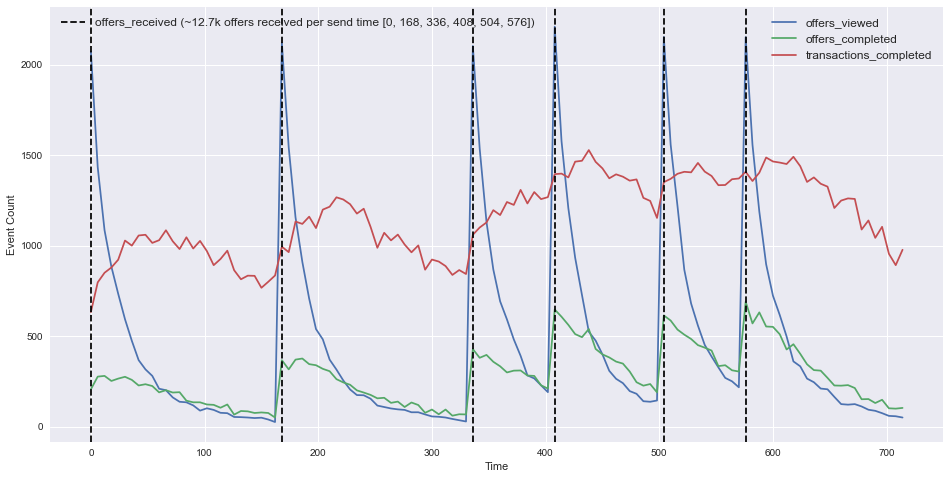

In [38]:
dfvc = dfv.append(dfc).append(trs)
fig, ax = plt.subplots(figsize=(16, 8))

for event_name in dfvc.event_name.unique():
    data = dfvc[dfvc.event_name==event_name]
    ax.plot(data.time, data.event_count, label=event_name)

for time in df_received.offer_received_time.unique():
    tvl = ax.axvline(time, color='k', linestyle='--')
    
ax.set_xlabel("Time")
ax.set_ylabel("Event Count")
legend1 = ax.legend(loc='upper right', fontsize=12)
legend2 = ax.legend([tvl], ['offers_received (~12.7k offers received per send time [0, 168, 336, 408, 504, 576])'], fontsize=12, loc='upper left')
ax.add_artist(legend1); # add back legend1


In [39]:
plt.savefig('../output/diagnostic_metrics/offer_time_series_chart.png', dpi = 300, bbox_inches = 'tight')

<Figure size 576x396 with 0 Axes>

In [40]:
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
profile = profile.rename(columns={'id': 'customer_id', 'became_member_on': 'date_registered'})
profile['date_registered'] = profile['date_registered'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))

In [41]:
print(df_received.customer_id.nunique())
print(profile.customer_id.nunique())
# 16,994 customers have received at least one offer during their lifetime among total of 17k members

16994
17000


In [42]:
base_cnt = df_received.groupby('customer_id')['offer_id'].count().reset_index()
base_cnt.groupby('offer_id')['customer_id'].count().reset_index().rename(columns={'offer_id': 'num_offers_received', 
                                                                                  'customer_id': 'customer_count'})


,num_offers_received,customer_count
0,1,73
1,2,610
2,3,2325
3,4,4988
4,5,5931
5,6,3067


## Preprocessing: Offers Received Expanded Dataset

In [43]:
print(X_train.shape)
print(X_test.shape)

(11390, 40)
(5610, 40)


## Merge X_train with X_train_received, and X_test with X_test_received

In [44]:
df_received = df_base.create_df_base_received(df_transcript)
df_received_expanded = df_received.merge(df_portfolio, how='left', on='offer_id')
df_received_expanded.drop(columns=['offer_received'], inplace=True)
df_received_expanded[df_received_expanded.offer_received_time==0].groupby('offer_type_v2')['offer_id'].count()

offer_type_v2
bogo-10-10-120          1218
bogo-10-10-168          1292
bogo-5-5-120            1263
bogo-5-5-168            1245
discount-2-10-168       1257
discount-2-10-240       1318
discount-3-7-168        1221
discount-5-20-240       1297
informational-0-0-72    1266
informational-0-0-96    1273
Name: offer_id, dtype: int64

In [48]:
df_received_expanded.shape

(76277, 16)

In [49]:
X_train_customer_ids = train.customer_id.reset_index().drop(columns=['index'])
X_train_received = df_received_expanded.merge(X_train_customer_ids, how='inner', on='customer_id')
X_train_received.shape

(51058, 16)

In [53]:
X_train = pd.concat([X_train_customer_ids, X_train], axis=1)
X_train_v2 = X_train_received.merge(X_train, how='left', on='customer_id')
X_train_v2.shape

(51058, 56)

In [58]:
X_test_customer_ids = test.customer_id.reset_index().drop(columns=['index'])
X_test_received = df_received_expanded.merge(X_test_customer_ids, how='inner', on='customer_id')
X_test_received.shape

(25219, 16)

In [60]:
X_test = pd.concat([X_test_customer_ids, X_test], axis=1)
X_test_v2 = X_test_received.merge(X_test, how='left', on='customer_id')
X_test_v2.shape

(25219, 56)

In [61]:
X_train_v2.head()

,customer_id,offer_received_time,offer_id,reward,difficulty,duration,offer_type,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_informational,type_discount,offer_type_v2,age,days_registered,income,transaction_amount,transaction_cnt,transaction_aos,num_offer_received,num_bogo_offer_received,num_info_offer_received,num_discount_offer_received,num_offer_viewed,num_offer_completed,num_offer_completed_viewed,num_offer_completed_not_viewed,num_transactions_oc_direct,num_transactions_oc_indirect,percent_oc_direct_transactions,total_reward_amount,avg_reward_per_oc_transaction,transaction_oc_amount,transaction_aos_oc,transaction_no_oc_amount,transaction_aos_no_oc,num_bogo_offer_viewed,num_info_offer_viewed,num_discount_offer_viewed,num_bogo_offer_completed,num_discount_offer_completed,median_offer_duration,avg_offer_completion_time,avg_hrs_bw_transactions,num_oc_ch_social,avg_offer_received_freq,info_view_rate,gender_F,gender_M,gender_Missing,age_quantile_label_enc,days_reg_quantile_label_enc,income_quantile_label_enc
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,3,1,1,1,0,1,0,0,bogo-5-5-168,75.0,443,100000.0,180.99,7.0,25.86,4.0,3.0,1.0,0.0,4.0,3.0,2.0,1.0,2.0,0.0,0.2857,20.0,10.0,63.33,31.665,117.66,23.532,3.0,1.0,0.0,3.0,0.0,168.0,80.0,57.428571,2.0,168.0,1.0,1.0,0.0,0.0,4,5,4
1,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,0,72,informational,3,0,1,1,1,0,1,0,informational-0-0-72,75.0,443,100000.0,180.99,7.0,25.86,4.0,3.0,1.0,0.0,4.0,3.0,2.0,1.0,2.0,0.0,0.2857,20.0,10.0,63.33,31.665,117.66,23.532,3.0,1.0,0.0,3.0,0.0,168.0,80.0,57.428571,2.0,168.0,1.0,1.0,0.0,0.0,4,5,4
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,bogo,3,0,1,1,1,1,0,0,bogo-10-10-168,75.0,443,100000.0,180.99,7.0,25.86,4.0,3.0,1.0,0.0,4.0,3.0,2.0,1.0,2.0,0.0,0.2857,20.0,10.0,63.33,31.665,117.66,23.532,3.0,1.0,0.0,3.0,0.0,168.0,80.0,57.428571,2.0,168.0,1.0,1.0,0.0,0.0,4,5,4
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,bogo,4,1,1,1,1,1,0,0,bogo-5-5-120,75.0,443,100000.0,180.99,7.0,25.86,4.0,3.0,1.0,0.0,4.0,3.0,2.0,1.0,2.0,0.0,0.2857,20.0,10.0,63.33,31.665,117.66,23.532,3.0,1.0,0.0,3.0,0.0,168.0,80.0,57.428571,2.0,168.0,1.0,1.0,0.0,0.0,4,5,4
4,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,240,discount,2,1,1,0,0,0,0,1,discount-5-20-240,55.0,356,64000.0,4.65,3.0,1.55,5.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00,0.000,4.65,1.550,0.0,1.0,2.0,0.0,0.0,0.0,0.0,189.000000,0.0,144.0,0.5,0.0,0.0,1.0,2,4,2


In [62]:
X_train_v2.groupby('offer_type_v2')['customer_id'].count().reset_index()

,offer_type_v2,customer_id
0,bogo-10-10-120,5086
1,bogo-10-10-168,5088
2,bogo-5-5-120,5148
3,bogo-5-5-168,5107
4,discount-2-10-168,5054
5,discount-2-10-240,5109
6,discount-3-7-168,5135
7,discount-5-20-240,5143
8,informational-0-0-72,5112
9,informational-0-0-96,5076


In [63]:
X_test_v2.groupby('offer_type_v2')['customer_id'].count().reset_index()

,offer_type_v2,customer_id
0,bogo-10-10-120,2507
1,bogo-10-10-168,2570
2,bogo-5-5-120,2423
3,bogo-5-5-168,2570
4,discount-2-10-168,2578
5,discount-2-10-240,2488
6,discount-3-7-168,2511
7,discount-5-20-240,2525
8,informational-0-0-72,2506
9,informational-0-0-96,2541


## Merge trans_engage to X_train_v2 and X_test_v2

In [64]:
trans_engage = pd.read_csv('../data/starbucks_transaction_engagement.csv.gz', compression='gzip')
trans_engage.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time,reward,difficulty,duration,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_informational,type_discount
0,58bf145c78c443ab8a30f358c5366df3,ade32d0843cd496c9a50489e63db682d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,177f4b3890ee48e7ad802f3da8d88fbb,7f400c9706c9474a998163ab71d5f7d5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0,2.0,10.0,168.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,72b8956eb18f4fd1b8529756b0c49891,b646978a8d3e43e2ae9ee0320f7853a7,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8723f4108ad5402a89c083d76a4208d3,00b7f2a712af4ff79b622117024eb6c5,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5e905d5ca7444f0b992edad9866ad4ed,b3ac815535d941dd86e945dc03f750b8,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1,2.0,10.0,240.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [65]:
# using transaction engagement data mart isolate all transaction_id's with offer_completed = 1
selected_columns = ['customer_id', 'offer_id', 'offer_completed', 'offer_completed_time', 'offer_received_time']
trans_offer_completed = trans_engage[selected_columns][trans_engage.offer_completed == 1]
print(trans_offer_completed.shape)
trans_offer_completed.drop_duplicates(inplace=True)
print(trans_offer_completed.shape)

(33182, 5)
(33182, 5)


In [66]:
# join by customer_id, offer_id, and offer_received_time
X_train_v3 = X_train_v2.merge(trans_offer_completed, 
                              how='left', 
                              on=['customer_id', 'offer_id', 'offer_received_time'])
X_train_v3.drop_duplicates(inplace=True)
X_train_v3['offer_completed'].fillna(0, inplace=True)
X_train_v3['offer_completed_time'].fillna(-1, inplace=True)
X_train_v3.shape

(51116, 58)

In [67]:
# join by customer_id, offer_id, and offer_received_time
X_test_v3 = X_test_v2.merge(trans_offer_completed, 
                            how='left', 
                            on=['customer_id', 'offer_id', 'offer_received_time'])
X_test_v3.drop_duplicates(inplace=True)
X_test_v3['offer_completed'].fillna(0, inplace=True)
X_test_v3['offer_completed_time'].fillna(-1, inplace=True)
X_test_v3.shape

(25242, 58)

* Two model pipelines
    * BOGO and Discounts - predicting completing offer
    * Informational - predicting viewing the informational content

In [68]:
X_train_v3.offer_type_v2.value_counts()

discount-5-20-240       5164
bogo-5-5-120            5148
discount-3-7-168        5141
discount-2-10-240       5136
informational-0-0-72    5112
bogo-5-5-168            5107
bogo-10-10-168          5088
bogo-10-10-120          5086
informational-0-0-96    5076
discount-2-10-168       5058
Name: offer_type_v2, dtype: int64

## discount_5_20_240 train and test

In [69]:
DROP_COLUMNS = ['customer_id', 'reward', 'difficulty', 'duration', 'num_channels',
                'ch_web', 'ch_email', 'ch_mobile', 'ch_social', 'type_bogo', 'type_informational', 
                'type_discount', 'offer_id', 'offer_type', 'offer_type_v2', 'offer_completed_time']

In [70]:
train_discount_5_20_240 = X_train_v3[X_train_v3.offer_type_v2=='discount-5-20-240']
train_d520240_cid = train_discount_5_20_240.customer_id.tolist()
train_discount_5_20_240.drop(columns=DROP_COLUMNS, inplace=True)
train_discount_5_20_240.head()

,offer_received_time,age,days_registered,income,transaction_amount,transaction_cnt,transaction_aos,num_offer_received,num_bogo_offer_received,num_info_offer_received,num_discount_offer_received,num_offer_viewed,num_offer_completed,num_offer_completed_viewed,num_offer_completed_not_viewed,num_transactions_oc_direct,num_transactions_oc_indirect,percent_oc_direct_transactions,total_reward_amount,avg_reward_per_oc_transaction,transaction_oc_amount,transaction_aos_oc,transaction_no_oc_amount,transaction_aos_no_oc,num_bogo_offer_viewed,num_info_offer_viewed,num_discount_offer_viewed,num_bogo_offer_completed,num_discount_offer_completed,median_offer_duration,avg_offer_completion_time,avg_hrs_bw_transactions,num_oc_ch_social,avg_offer_received_freq,info_view_rate,gender_F,gender_M,gender_Missing,age_quantile_label_enc,days_reg_quantile_label_enc,income_quantile_label_enc,offer_completed
4,0,55.0,356,64000.0,4.65,3.0,1.55,5.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,4.65,1.550000,0.0,1.0,2.0,0.0,0.0,0.0,0.0,189.000000,0.0,144.0,0.5,0.0,0.0,1.0,2,4,2,0.0
7,504,55.0,356,64000.0,4.65,3.0,1.55,5.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,4.65,1.550000,0.0,1.0,2.0,0.0,0.0,0.0,0.0,189.000000,0.0,144.0,0.5,0.0,0.0,1.0,2,4,2,0.0
8,576,55.0,356,64000.0,4.65,3.0,1.55,5.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,4.65,1.550000,0.0,1.0,2.0,0.0,0.0,0.0,0.0,189.000000,0.0,144.0,0.5,0.0,0.0,1.0,2,4,2,0.0
17,0,61.0,318,57000.0,85.55,6.0,14.26,5.0,3.0,1.0,1.0,5.0,3.0,2.0,1.0,3.0,0.0,0.5,25.0,8.33,40.84,13.613333,44.71,14.903333,3.0,1.0,1.0,3.0,0.0,120.0,38.0,84.000000,3.0,144.0,1.0,1.0,0.0,0.0,3,4,1,0.0
22,0,62.0,896,71000.0,160.25,8.0,20.03,6.0,0.0,0.0,6.0,5.0,4.0,3.0,1.0,4.0,0.0,0.5,11.0,2.75,75.32,18.830000,84.93,21.232500,0.0,0.0,5.0,0.0,4.0,168.0,46.5,40.285714,4.0,115.2,0.0,1.0,0.0,0.0,3,8,3,0.0


In [71]:
test_discount_5_20_240 = X_test_v3[X_test_v3.offer_type_v2=='discount-5-20-240']
test_d520240_cid = test_discount_5_20_240.customer_id.tolist()
test_discount_5_20_240.drop(columns=DROP_COLUMNS, inplace=True)
test_discount_5_20_240.head()

,offer_received_time,age,days_registered,income,transaction_amount,transaction_cnt,transaction_aos,num_offer_received,num_bogo_offer_received,num_info_offer_received,num_discount_offer_received,num_offer_viewed,num_offer_completed,num_offer_completed_viewed,num_offer_completed_not_viewed,num_transactions_oc_direct,num_transactions_oc_indirect,percent_oc_direct_transactions,total_reward_amount,avg_reward_per_oc_transaction,transaction_oc_amount,transaction_aos_oc,transaction_no_oc_amount,transaction_aos_no_oc,num_bogo_offer_viewed,num_info_offer_viewed,num_discount_offer_viewed,num_bogo_offer_completed,num_discount_offer_completed,median_offer_duration,avg_offer_completion_time,avg_hrs_bw_transactions,num_oc_ch_social,avg_offer_received_freq,info_view_rate,gender_F,gender_M,gender_Missing,age_quantile_label_enc,days_reg_quantile_label_enc,income_quantile_label_enc,offer_completed
23,576,22.0,304,70000.0,127.01,6.0,21.17,6.0,3.0,1.0,2.0,6.0,4.0,4.0,0.0,3.0,0.0,0.5000,28.0,9.33,87.19,29.063333,39.82,13.273333,3.0,1.0,2.0,2.0,2.0,144.0,34.5,67.000000,3.0,115.2,1.0,0.0,1.0,0.0,0,4,3,1.0
44,168,55.0,441,64000.0,51.71,16.0,3.23,5.0,1.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0000,2.0,2.00,8.53,8.530000,43.18,2.878667,1.0,0.0,3.0,0.0,1.0,240.0,96.0,44.000000,1.0,126.0,0.0,0.0,0.0,1.0,2,5,2,0.0
46,408,55.0,441,64000.0,51.71,16.0,3.23,5.0,1.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0000,2.0,2.00,8.53,8.530000,43.18,2.878667,1.0,0.0,3.0,0.0,1.0,240.0,96.0,44.000000,1.0,126.0,0.0,0.0,0.0,1.0,2,5,2,0.0
47,504,55.0,441,64000.0,51.71,16.0,3.23,5.0,1.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0000,2.0,2.00,8.53,8.530000,43.18,2.878667,1.0,0.0,3.0,0.0,1.0,240.0,96.0,44.000000,1.0,126.0,0.0,0.0,0.0,1.0,2,5,2,0.0
52,576,39.0,1521,51000.0,51.91,14.0,3.71,5.0,2.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0714,5.0,5.00,7.16,7.160000,44.75,3.442308,2.0,1.0,0.0,1.0,0.0,120.0,48.0,42.461538,1.0,144.0,0.5,0.0,1.0,0.0,0,9,1,0.0


In [72]:
X_train_d520240 = train_discount_5_20_240.iloc[:, :-1]
y_train_d520240 = train_discount_5_20_240.iloc[:, -1:]

In [73]:
X_test_d520240 = test_discount_5_20_240.iloc[:, :-1]
y_test_d520240 = test_discount_5_20_240.iloc[:, -1:]

In [74]:
rf_estimator = RandomForestClassifier(random_state=0)
rf_estimator.fit(X_train_d520240, y_train_d520240)

y_pred = rf_estimator.predict(X_test_d520240)
print("Accuracy: {}".format(metrics.accuracy_score(y_test_d520240, y_pred)))

Accuracy: 0.924930857368629


In [75]:
y_pred_proba = rf_estimator.predict_proba(X_test_d520240)
y_max_pred_proba = [max(vals) for vals in y_pred_proba]

In [76]:
test_d520240_predictions = pd.DataFrame({'y_pred': list(y_pred), 
                                         'y_max_pred_proba': y_max_pred_proba, 
                                         'y_pred_proba': list(y_pred_proba)})
test_d520240_predictions.head(10)

,y_pred,y_max_pred_proba,y_pred_proba
0,1.0,0.66,"[0.34, 0.66]"
1,0.0,1.00,"[1.0, 0.0]"
2,0.0,1.00,"[1.0, 0.0]"
3,0.0,1.00,"[1.0, 0.0]"
4,0.0,0.99,"[0.99, 0.01]"
5,1.0,0.58,"[0.42, 0.58]"
6,1.0,0.86,"[0.14, 0.86]"
7,1.0,0.90,"[0.1, 0.9]"
8,0.0,0.99,"[0.99, 0.01]"
9,0.0,1.00,"[1.0, 0.0]"


<AxesSubplot:>

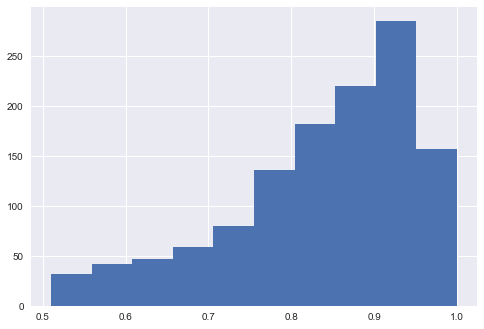

In [77]:
# prediction confidence of customers who were predicted as "1"
test_d520240_predictions[test_d520240_predictions.y_pred==1]['y_max_pred_proba'].hist()

In [78]:
feature_ranking(X_train_d520240, len(X_train_d520240.columns), rf_estimator.feature_importances_)

# 1. remove highly correlated features using pearson (linear) and spearman (monotonic) correlation (both over 0.95)
# 2. remove least important features through RF feature importance -> define arbitrary cutoff threshold (>0.01)
# 3. remove least important features through permutation importance
# 4. Re-run model 
# 5. RandomizedSearch to tune hyperparamters
# 6. Deploy model to production

,importance
total_reward_amount,0.090473
transaction_oc_amount,0.090468
num_offer_completed,0.085251
transaction_amount,0.079346
num_discount_offer_completed,0.077840
avg_reward_per_oc_transaction,0.065191
offer_received_time,0.059765
transaction_aos_no_oc,0.045654
median_offer_duration,0.043792
transaction_aos_oc,0.042792


In [79]:
cor_matrix = X_train_d520240.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

[]


### Model build per offer_type_v2

* Focus only on BOGO and Discounts because Informational with Social already has close to 90% view rate.
* Build X_train_v3 and X_test_v3.
* For each offer_type_v2, filter out subset data from X_train_v3 and X_test_v3.
    * e.g., train_discount_5_20_240 and test_discount_5_20_240
* Create X_train and y_train, and X_test and y_test from the subset data
    * X_train_d520240 = train_discount_5_20_240.iloc[:, :-1]
    * y_train_d520240 = train_discount_5_20_240.iloc[:, -1:]
    * X_test_d520240 = test_discount_5_20_240.iloc[:, :-1]
    * y_test_d520240 = test_discount_5_20_240.iloc[:, -1:]
* Remove highly correlated features using Pearson and Spearman
* Train RandomForestClassifier(random_state=0)
* Use RF feature importance and permutation importance to identify important features
* Re-train RF model after feature selection
* Optimize RF hyperparameters using Randomized Search
* Create final RF estimator and save

* This step is applied to 4 BOGOs and 4 Discounts, which will generate 8 unique model estimators